In [1]:
!nvidia-smi

Sat Nov 15 22:42:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8              9W /  220W |    5886MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_allocated()
torch.cuda.memory_reserved()
import zipfile
import os
import nibabel as nib
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torch.utils.data import random_split
import wandb
from torchvision import models
import torch.optim as optim




In [3]:
%run src/ConvNext_models.ipynb
%run src/metrics.ipynb
%run src/hg_lossfunctions.ipynb
%run src/trainer.ipynb
%run src/BratsDataloader.ipynb
%run src/Optimizer.ipynb
%run src/UNET.ipynb

Output: torch.Size([2, 1, 512, 512])
Path BrATS2021: BrATS2021/
Path BrATS2023: BrATS2023/


In [4]:
base_path ="../datasets/BRATS2024/"


transform = transforms.Compose([
    transforms.Resize((512, 512)),



])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512))
])



dataset = BRATSDataset_2(base_path, img_transform=transform, mask_transform = mask_transform)

train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


BATCH_SIZE = 6
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size   = BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size  = BATCH_SIZE, shuffle=False)
print(np.shape(train_loader))
for img, mask in train_loader:
    print(np.shape(img))
    print(np.shape(mask))
    break

def get_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params


def get_model_memory_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    return param_size
def get_model_flops(model, input_size=(1, 512, 512), device='cuda'):
    model = model.to(device)
    model.eval()

    total_flops = 0
    total_params = sum(p.numel() for p in model.parameters())

()
torch.Size([6, 1, 512, 512])
torch.Size([6, 1, 512, 512])


In [7]:
import os
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from PIL import Image




class MultiFeatureStem(nn.Module):
    def __init__(self, *, in_ch: int, out_ch: int):
        super().__init__()
        split  = out_ch // 3
        ch_cfg = [split, split, out_ch - 2 * split]
        ks_pad = [(3, 1), (5, 2), (7, 3)]

        self.branches = nn.ModuleList(
            nn.Conv2d(in_ch, ch_cfg[i], kernel_size=k, stride=4, padding=p, bias=False)
            for i, (k, p) in enumerate(ks_pad)
        )
        self.bn  = nn.BatchNorm2d(out_ch)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.cat([b(x) for b in self.branches], dim=1)
        return self.act(self.bn(x))





class SkipReverseAttn(nn.Module):
    def __init__(self, channels: int, dropout_p: float = 0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(channels)
        self.act   = nn.GELU()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(channels)
        self.sig   = nn.Sigmoid()

        self.drop  = nn.Dropout2d(dropout_p) if dropout_p > 0 else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        m = self.act(self.bn1(self.conv1(x)))
        m = self.sig(self.bn2(self.conv2(m)))

        out = x * (1.0 - m) + x

        return self.drop(out)






class ConvNeXtSegmentationMF(nn.Module):
    def __init__(
        self,
        num_classes: int = 1,
        backbone_type: str = "base",
        dropout_p: float = 0.0,
    ):
        """
        num_classes : 1 -> segmentación binaria (usa sigmoid fuera)
                      >1 -> multiclase (usa softmax fuera)
        backbone_type : "tiny" | "small" | "base" | "large"
        dropout_p : prob. de Dropout2d en decoder y RA (0.0 = apagado)
        """
        super().__init__()

        cfg = {
            "tiny":  dict(fn=models.convnext_tiny , w=models.ConvNeXt_Tiny_Weights.DEFAULT ,
                          ch=[ 96, 192, 384,  768]),
            "small": dict(fn=models.convnext_small, w=models.ConvNeXt_Small_Weights.DEFAULT,
                          ch=[ 96, 192, 384,  768]),
            "base":  dict(fn=models.convnext_base , w=models.ConvNeXt_Base_Weights.DEFAULT ,
                          ch=[128, 256, 512, 1024]),
            "large": dict(fn=models.convnext_large, w=models.ConvNeXt_Large_Weights.DEFAULT,
                          ch=[192, 384, 768, 1536]),
        }
        assert backbone_type in cfg, "Backbone no soportado."
        self.ch = cfg[backbone_type]["ch"]
        self.num_classes = num_classes
        self.dropout_p = dropout_p


        self.stem = MultiFeatureStem(in_ch=1, out_ch=self.ch[0])


        enc_full = cfg[backbone_type]["fn"](weights=cfg[backbone_type]["w"]).features
        self.encoder = nn.Sequential(*enc_full[1:])


        self.ra3 = SkipReverseAttn(self.ch[2], dropout_p=dropout_p)
        self.ra2 = SkipReverseAttn(self.ch[1], dropout_p=dropout_p)
        self.ra1 = SkipReverseAttn(self.ch[0], dropout_p=dropout_p)


        self.up4 = self._up(self.ch[3]   , self.ch[2], dropout_p)
        self.up3 = self._up(self.ch[2]*2 , self.ch[1], dropout_p)
        self.up2 = self._up(self.ch[1]*2 , self.ch[0], dropout_p)
        self.up1 = self._up(self.ch[0]*2 , 64        , dropout_p)
        self.up0 = self._up(64           , 32        , dropout_p)
        self.final_conv = nn.Conv2d(32, num_classes, 1)

    @staticmethod
    def _up(in_ch: int, out_ch: int, dropout_p: float = 0.0) -> nn.Sequential:
        layers = [
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.GELU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.GELU(),
        ]
        if dropout_p > 0:
            layers.append(nn.Dropout2d(dropout_p))
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.stem(x)
        skip1 = x

        skip2 = None
        skip3 = None

        for layer in self.encoder:
            x = layer(x)
            c = x.shape[1]
            if c == self.ch[1]:
                skip2 = x
            elif c == self.ch[2]:
                skip3 = x




        x = self.up4(x)
        x = torch.cat([x, self.ra3(skip3)], dim=1)


        x = self.up3(x)
        x = torch.cat([x, self.ra2(skip2)], dim=1)


        x = self.up2(x)
        x = torch.cat([x, self.ra1(skip1)], dim=1)


        x = self.up1(x)
        x = self.up0(x)
        logits = self.final_conv(x)
        return logits






def enable_mc_dropout(model: nn.Module):
    """
    Activa todos los módulos Dropout/Dropout2d/Dropout3d en modo train,
    dejando el resto del modelo en eval(). Útil para MC Dropout.
    """
    for m in model.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
            m.train()


@torch.no_grad()
def mc_dropout_forward(
    model: nn.Module,
    x: torch.Tensor,
    n_samples: int = 20,
    num_classes: int = 1,
):
    """
    MC Dropout para epistemic uncertainty.
    x : [B, C, H, W]
    Devuelve:
      mean_prob    : [B, C, H, W]
      epistemic_var: [B, C, H, W]
    """
    device = next(model.parameters()).device
    x = x.to(device)


    model.eval()
    enable_mc_dropout(model)

    preds = []
    for _ in range(n_samples):
        logits = model(x)
        if num_classes == 1:
            prob = torch.sigmoid(logits)
        else:
            prob = torch.softmax(logits, dim=1)
        preds.append(prob)

    preds = torch.stack(preds, dim=0)
    mean_prob = preds.mean(dim=0)
    epistemic_var = preds.var(dim=0)

    return mean_prob, epistemic_var






def save_gray_image(array_2d: np.ndarray, path: str):
    """
    array_2d: [H, W] en float (cualquier rango).
    Se normaliza a [0,1] y se guarda como PNG 8 bits.
    """
    arr = array_2d.astype(np.float32)
    arr = arr - arr.min()
    if arr.max() > 0:
        arr = arr / arr.max()
    arr = (arr * 255).astype(np.uint8)
    img = Image.fromarray(arr)
    img.save(path)


def run_mc_dropout_on_test_loader(
    model: nn.Module,
    test_loader,
    device: torch.device,
    out_dir: str,
    num_classes: int = 1,
    n_samples: int = 20,
    thr: float = 0.5,
):
    """
    Recorre el test_loader, aplica MC Dropout y guarda:
      - mapa de probabilidad (mean_prob)
      - máscara predicha (pred)
      - mapa de incertidumbre epistémica (varianza)

    Asume que cada batch es:
      (imgs, masks)  o  (imgs, masks, names)
    """
    os.makedirs(out_dir, exist_ok=True)
    prob_dir = os.path.join(out_dir, "prob")
    pred_dir = os.path.join(out_dir, "pred")
    unc_dir  = os.path.join(out_dir, "uncertainty")
    os.makedirs(prob_dir, exist_ok=True)
    os.makedirs(pred_dir, exist_ok=True)
    os.makedirs(unc_dir,  exist_ok=True)

    model.to(device)

    batch_index = 0
    for batch in test_loader:

        if isinstance(batch, (list, tuple)):
            if len(batch) == 3:
                imgs, masks, names = batch
            elif len(batch) == 2:
                imgs, masks = batch

                names = [f"sample_{batch_index}_{i}" for i in range(imgs.size(0))]
            else:
                raise ValueError("El batch no tiene forma esperada (2 o 3 elementos).")
        else:
            raise ValueError("Se esperaba que el batch fuera una tupla/lista.")

        mean_prob, epistemic_var = mc_dropout_forward(
            model,
            imgs,
            n_samples=n_samples,
            num_classes=num_classes,
        )


        if num_classes == 1:
            preds = (mean_prob > thr).float()
            mean_prob_np = mean_prob.squeeze(1).cpu().numpy()
            preds_np     = preds.squeeze(1).cpu().numpy()
            unc_np       = epistemic_var.squeeze(1).cpu().numpy()
        else:

            preds = mean_prob.argmax(dim=1)
            mean_prob_np = mean_prob.cpu().numpy()
            preds_np     = preds.cpu().numpy()
            unc_np       = epistemic_var.mean(dim=1).cpu().numpy()


        B = len(names)
        for i in range(B):
            name = names[i]

            if isinstance(name, str):
                stem = os.path.splitext(os.path.basename(name))[0]
            else:
                stem = f"sample_{batch_index}_{i}"

            if num_classes == 1:
                prob_i = mean_prob_np[i]
                pred_i = preds_np[i]
            else:
                prob_i = mean_prob_np[i, 1] if mean_prob_np.shape[1] > 1 else mean_prob_np[i, 0]
                pred_i = preds_np[i]

            unc_i  = unc_np[i]

            prob_path = os.path.join(prob_dir, f"{stem}_prob.png")
            pred_path = os.path.join(pred_dir, f"{stem}_pred.png")
            unc_path  = os.path.join(unc_dir,  f"{stem}_unc.png")

            save_gray_image(prob_i, prob_path)
            save_gray_image(pred_i, pred_path)
            save_gray_image(unc_i,  unc_path)

        batch_index += 1

    print(f"Listo. Resultados guardados en: {out_dir}")





if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    CHECKPOINT_PATH = "pretrained_model/ConvNeXtSegmentationMF_fold5.pth"


    BACKBONE_TYPE = "base"


    NUM_CLASSES = 1


    DROPOUT_P = 0.1


    model = ConvNeXtSegmentationMF(
        num_classes=NUM_CLASSES,
        backbone_type=BACKBONE_TYPE,
        dropout_p=DROPOUT_P,
    ).to(device)


    state = torch.load(CHECKPOINT_PATH, map_location=device)
    if isinstance(state, dict):
        if "state_dict" in state:
            state_dict = state["state_dict"]
        elif "model_state_dict" in state:
            state_dict = state["model_state_dict"]
        else:
            state_dict = state
    else:
        state_dict = state

    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print("Missing keys (normal si aparecen cosas de dropout):", missing)
    print("Unexpected keys:", unexpected)


    OUT_DIR   = "./mc_dropout_results_fold5"
    N_SAMPLES = 20
    THR       = 0.5


    run_mc_dropout_on_test_loader(
        model=model,
        test_loader=test_loader,
        device=device,
        out_dir=OUT_DIR,
        num_classes=NUM_CLASSES,
        n_samples=N_SAMPLES,
        thr=THR,
    )


Missing keys (normal si aparecen cosas de dropout): []
Unexpected keys: []
Listo. Resultados guardados en: ./mc_dropout_results_fold5


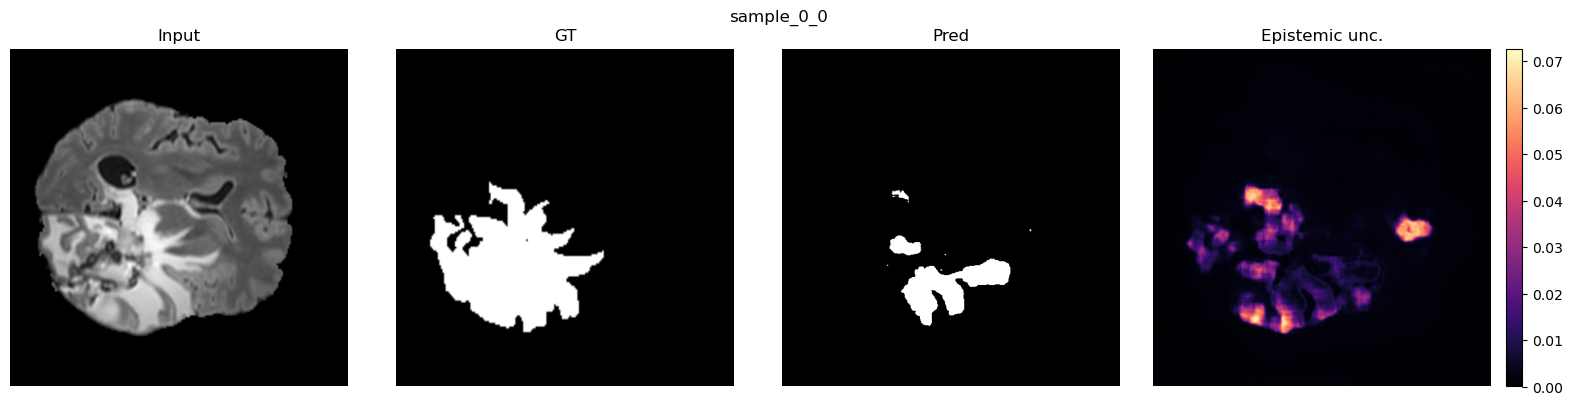

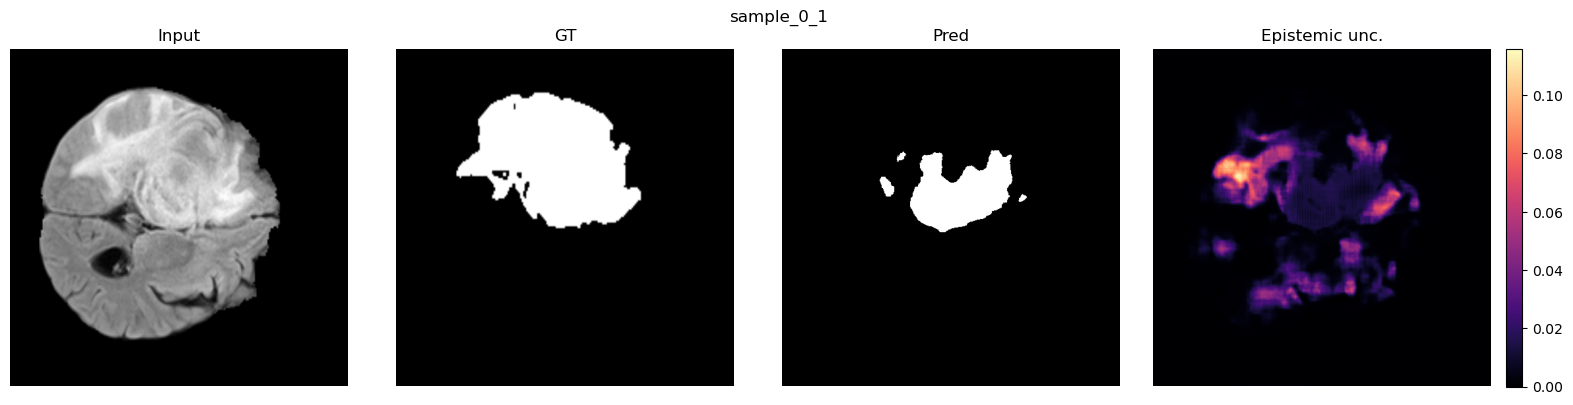

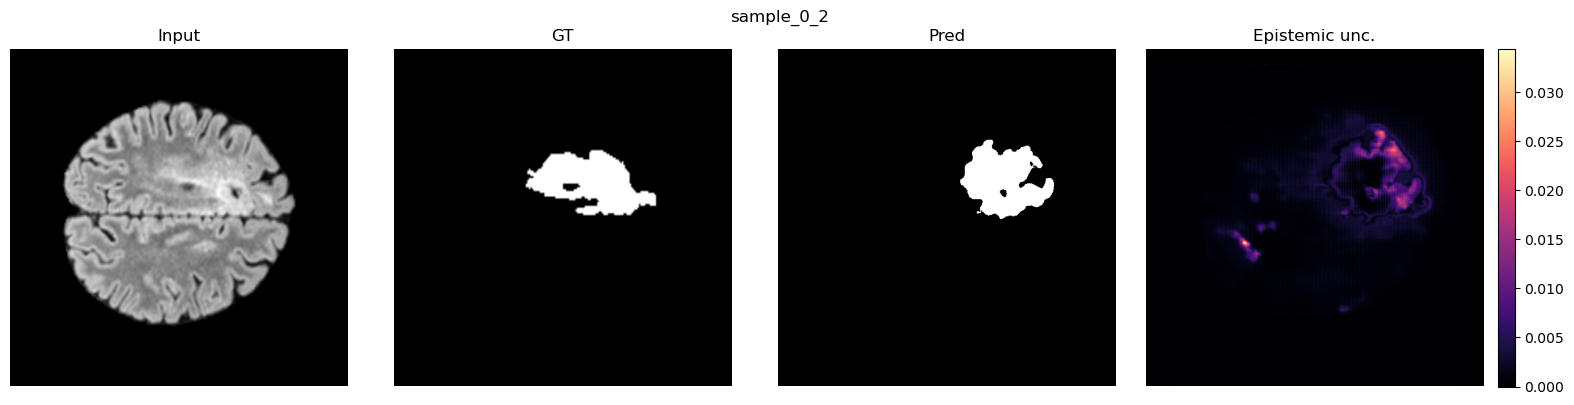

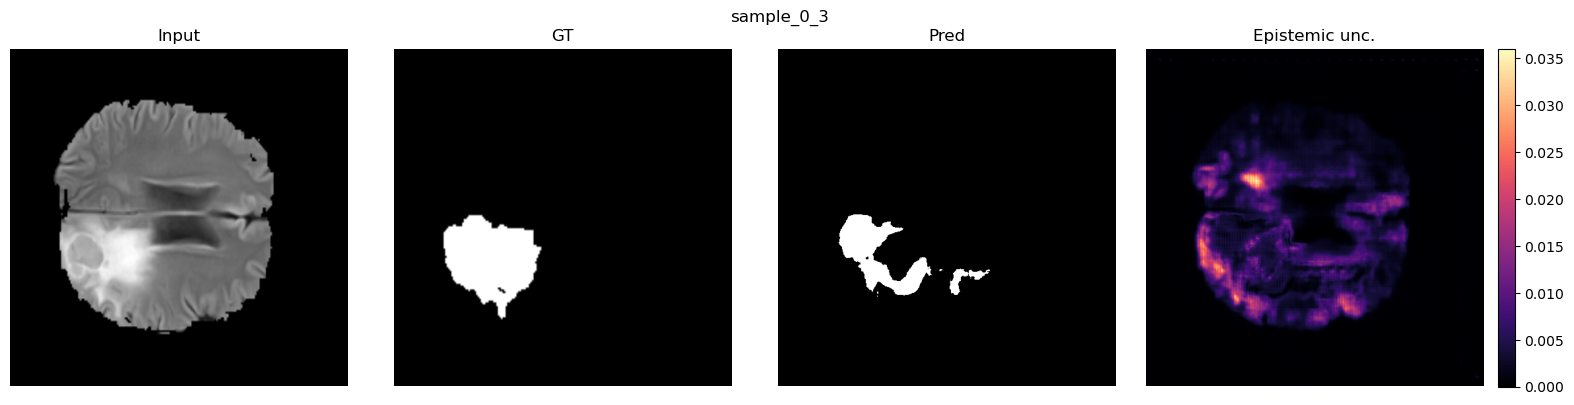

=== Mean epistemic uncertainty por tipo de voxel ===
TP (GT=1, Pred=1): 0.008197
FP (GT=0, Pred=1): 0.010716
FN (GT=1, Pred=0): 0.009703
TN (GT=0, Pred=0): 0.001757
{'TP_mean_unc': 0.008197098970413208, 'FP_mean_unc': 0.010715932585299015, 'FN_mean_unc': 0.009702537208795547, 'TN_mean_unc': 0.0017568375915288925}


In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt




def enable_mc_dropout(model: nn.Module):
    """
    Activa todos los módulos Dropout/Dropout2d/Dropout3d en modo train,
    dejando el resto del modelo en eval(). Útil para MC Dropout.
    """
    for m in model.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
            m.train()


@torch.no_grad()
def mc_dropout_forward(
    model: nn.Module,
    x: torch.Tensor,
    n_samples: int = 20,
    num_classes: int = 1,
):
    """
    MC Dropout para epistemic uncertainty.
    x : [B, C, H, W]
    Devuelve:
      mean_prob    : [B, C, H, W]
      epistemic_var: [B, C, H, W]
    """
    device = next(model.parameters()).device
    x = x.to(device)


    model.eval()
    enable_mc_dropout(model)

    preds = []
    for _ in range(n_samples):
        logits = model(x)
        if num_classes == 1:
            prob = torch.sigmoid(logits)
        else:
            prob = torch.softmax(logits, dim=1)
        preds.append(prob)

    preds = torch.stack(preds, dim=0)
    mean_prob = preds.mean(dim=0)
    epistemic_var = preds.var(dim=0)

    return mean_prob, epistemic_var





def show_examples_from_loader(
    model,
    test_loader,
    device=None,
    n_examples: int = 3,
    n_samples_mc: int = 20,
    thr: float = 0.5,
    num_classes: int = 1,
):
    """
    Muestra algunos casos: Input, GT, Pred, Uncertainty usando MC Dropout.
    """
    if device is None:
        device = next(model.parameters()).device

    model.to(device)

    shown = 0

    for batch in test_loader:

        if isinstance(batch, (list, tuple)):
            if len(batch) == 3:
                imgs, masks, names = batch
            elif len(batch) == 2:
                imgs, masks = batch
                names = [f"sample_{shown}_{i}" for i in range(imgs.size(0))]
            else:
                raise ValueError("Batch inesperado (se esperaban 2 o 3 elementos).")
        else:
            raise ValueError("El batch debe ser tupla/lista (imgs, masks[, names]).")

        imgs = imgs.to(device)
        masks = masks.to(device)

        mean_prob, epistemic_var = mc_dropout_forward(
            model,
            imgs,
            n_samples=n_samples_mc,
            num_classes=num_classes,
        )


        if num_classes == 1:
            preds = (mean_prob > thr).float()
            imgs_np  = imgs.detach().cpu().numpy()
            masks_np = masks.detach().cpu().numpy()
            preds_np = preds.detach().cpu().numpy()
            unc_np   = epistemic_var.detach().cpu().numpy()
        else:

            preds = mean_prob.argmax(dim=1, keepdim=True)
            imgs_np  = imgs.detach().cpu().numpy()
            masks_np = masks.detach().cpu().numpy()
            preds_np = preds.detach().cpu().numpy()

            unc_np   = epistemic_var.mean(dim=1, keepdim=True).detach().cpu().numpy()

        B = imgs_np.shape[0]

        for i in range(B):
            if shown >= n_examples:
                return

            img_i  = imgs_np[i]
            gt_i   = masks_np[i]
            pred_i = preds_np[i]
            unc_i  = unc_np[i]


            if img_i.ndim == 3:
                img_i = img_i[0]
            if gt_i.ndim == 3:
                gt_i = gt_i[0]
            if pred_i.ndim == 3:
                pred_i = pred_i[0]
            if unc_i.ndim == 3:
                unc_i = unc_i[0]


            img_min, img_max = img_i.min(), img_i.max()
            if img_max > img_min:
                img_vis = (img_i - img_min) / (img_max - img_min)
            else:
                img_vis = img_i

            fig, axs = plt.subplots(1, 4, figsize=(16, 4))
            axs[0].imshow(img_vis, cmap="gray")
            axs[0].set_title("Input")
            axs[0].axis("off")

            axs[1].imshow(gt_i, cmap="gray")
            axs[1].set_title("GT")
            axs[1].axis("off")

            axs[2].imshow(pred_i, cmap="gray")
            axs[2].set_title("Pred")
            axs[2].axis("off")

            im = axs[3].imshow(unc_i, cmap="magma")
            axs[3].set_title("Epistemic unc.")
            axs[3].axis("off")
            fig.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)

            if isinstance(names[i], str):
                fig.suptitle(str(names[i]))
            else:
                fig.suptitle(f"sample_{shown}")

            plt.tight_layout()
            plt.show()

            shown += 1
            if shown >= n_examples:
                return





def analyze_uncertainty_from_loader(
    model,
    test_loader,
    device=None,
    n_samples_mc: int = 20,
    thr: float = 0.5,
    num_classes: int = 1,
):
    """
    Calcula incertidumbre media de MC Dropout en TP, FP, FN, TN usando test_loader.

    Asume:
      - GT binaria (0/1)
      - Pred binaria (0/1) con el umbral 'thr'
      - epistemic_var en el mismo tamaño que pred (varianza sobre prob. en [0,1])
    """
    if device is None:
        device = next(model.parameters()).device

    model.to(device)

    all_tp_unc = []
    all_fp_unc = []
    all_fn_unc = []
    all_tn_unc = []

    for batch in test_loader:

        if isinstance(batch, (list, tuple)):
            if len(batch) == 3:
                imgs, masks, names = batch
            elif len(batch) == 2:
                imgs, masks = batch
            else:
                raise ValueError("Batch inesperado (se esperaban 2 o 3 elementos).")
        else:
            raise ValueError("El batch debe ser tupla/lista (imgs, masks[, names]).")

        imgs = imgs.to(device)
        masks = masks.to(device)

        mean_prob, epistemic_var = mc_dropout_forward(
            model,
            imgs,
            n_samples=n_samples_mc,
            num_classes=num_classes,
        )

        if num_classes == 1:
            preds = (mean_prob > thr).float()
            gt   = masks
            unc  = epistemic_var
        else:
            preds = mean_prob.argmax(dim=1, keepdim=True).float()
            gt    = masks.float()

            unc   = epistemic_var.mean(dim=1, keepdim=True)


        gt_np   = gt.detach().cpu().numpy()
        pred_np = preds.detach().cpu().numpy()
        unc_np  = unc.detach().cpu().numpy()


        if gt_np.ndim == 4:
            gt_np = gt_np[:, 0, :, :]
        if pred_np.ndim == 4:
            pred_np = pred_np[:, 0, :, :]
        if unc_np.ndim == 4:
            unc_np = unc_np[:, 0, :, :]

        gt_bin   = (gt_np >= 0.5).astype(np.uint8)
        pred_bin = (pred_np >= 0.5).astype(np.uint8)

        gt_f   = gt_bin.reshape(-1)
        pred_f = pred_bin.reshape(-1)
        unc_f  = unc_np.reshape(-1)

        tp_mask = (gt_f == 1) & (pred_f == 1)
        fp_mask = (gt_f == 0) & (pred_f == 1)
        fn_mask = (gt_f == 1) & (pred_f == 0)
        tn_mask = (gt_f == 0) & (pred_f == 0)

        if tp_mask.any():
            all_tp_unc.append(unc_f[tp_mask])
        if fp_mask.any():
            all_fp_unc.append(unc_f[fp_mask])
        if fn_mask.any():
            all_fn_unc.append(unc_f[fn_mask])
        if tn_mask.any():
            all_tn_unc.append(unc_f[tn_mask])

    def safe_mean(list_of_arrays):
        if len(list_of_arrays) == 0:
            return np.nan
        concat = np.concatenate(list_of_arrays)
        if concat.size == 0:
            return np.nan
        return float(concat.mean())

    tp_mean = safe_mean(all_tp_unc)
    fp_mean = safe_mean(all_fp_unc)
    fn_mean = safe_mean(all_fn_unc)
    tn_mean = safe_mean(all_tn_unc)

    print("=== Mean epistemic uncertainty por tipo de voxel ===")
    print(f"TP (GT=1, Pred=1): {tp_mean:.6f}")
    print(f"FP (GT=0, Pred=1): {fp_mean:.6f}")
    print(f"FN (GT=1, Pred=0): {fn_mean:.6f}")
    print(f"TN (GT=0, Pred=0): {tn_mean:.6f}")

    return {
        "TP_mean_unc": tp_mean,
        "FP_mean_unc": fp_mean,
        "FN_mean_unc": fn_mean,
        "TN_mean_unc": tn_mean,
    }





device = next(model.parameters()).device
NUM_CLASSES = 1
N_SAMPLES_MC = 20
THR = 0.5


show_examples_from_loader(
    model=model,
    test_loader=test_loader,
    device=device,
    n_examples=4,
    n_samples_mc=N_SAMPLES_MC,
    thr=THR,
    num_classes=NUM_CLASSES,
)


stats = analyze_uncertainty_from_loader(
    model=model,
    test_loader=test_loader,
    device=device,
    n_samples_mc=N_SAMPLES_MC,
    thr=THR,
    num_classes=NUM_CLASSES,
)
print(stats)
